### RNN Problems

RNNs have some disadvantages,   it suffers from the vanishing gradient problem(GRU and LSTMs can deal with this)

RNN, GRU and LSTM cannot learn the relationships between words and sentences that are far away from each other.

How to transform words, characters, strings into numerical data?

Representation of every single word in the vocabulary into features. Semantically similar words are closer to each other.

### Word2Vec

Embeddings: https://huggingface.co/spaces/hesamation/primer-llm-embedding?section=tf-idf_(term_frequency-inverse_document_frequency)

Word2Vec is a popular word embedding technique developed by Google (Mikolov et al., 2013) that represents words as dense vectors in a continuous vector space. There are two main architectures for Word2Vec: Continuous Bag of Words and Skip Gram

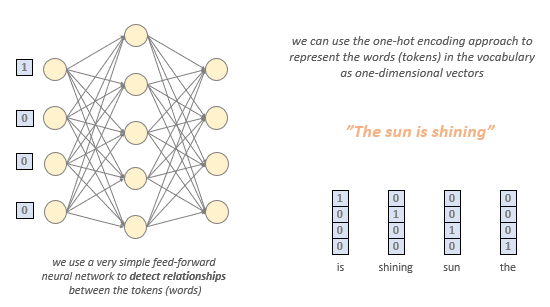

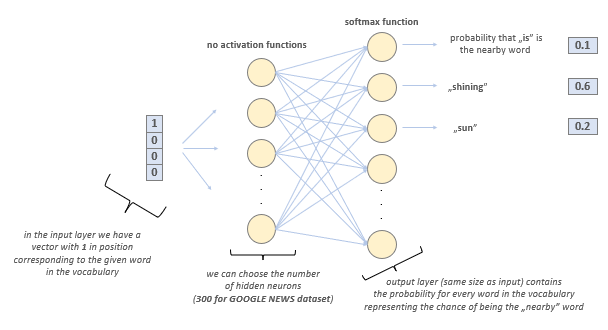


The final layer predicts the probability of  next word from the given word.

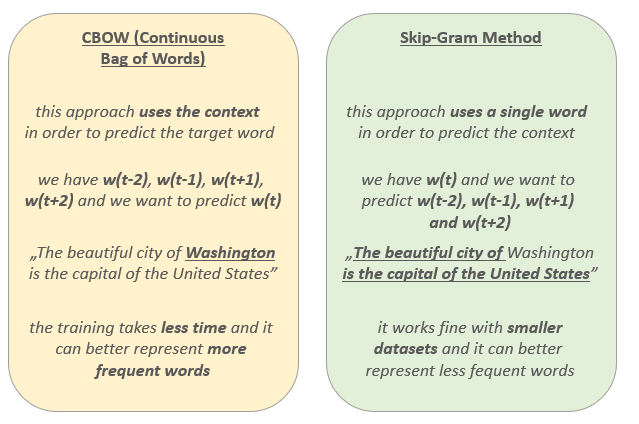

1) **Continuous Bag of words(CBOW)**:

Training Samples:

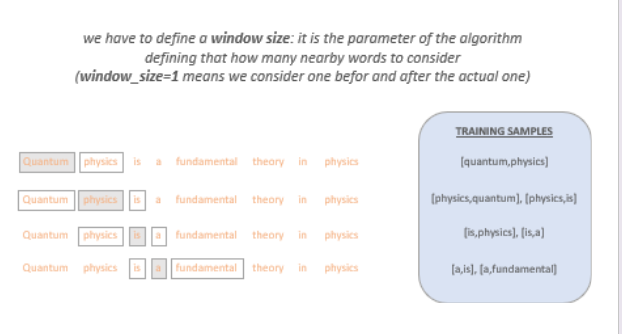

If the input word is quantum, then we need to predict physics
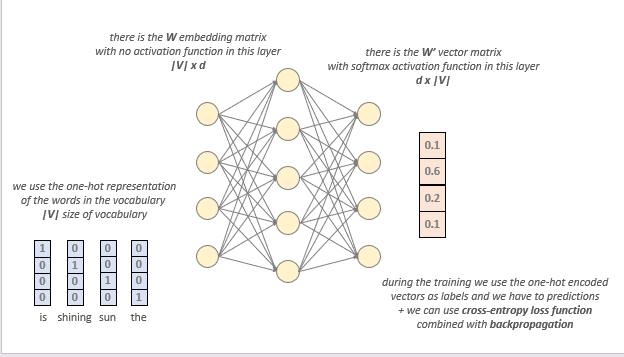


tokens = ["the", "quick", "brown", "fox", "jumps"]

CBOW (Context → Target)
Goal:
Predict the target word given its surrounding context words.

For each word (excluding borders), CBOW uses surrounding words to predict the center word.

Training pairs:

| Context (Input)     | Target (Output) |
| ------------------- | --------------- |
| \["the", "brown"]   | "quick"         |
| \["quick", "fox"]   | "brown"         |
| \["brown", "jumps"] | "fox"           |


Context size is 2 because we're taking 1 word from each side.

Mechanism:
Embed each context word

Average the embeddings

Use this to predict the target word via softmax

2) **SKIP GRAM**
predicts context words from a target word. For the same sentence and window size = 1.

Training Pairs:

| Target (Input) | Context (Output) |
| -------------- | ---------------- |
| "quick"        | "the"            |
| "quick"        | "brown"          |
| "brown"        | "quick"          |
| "brown"        | "fox"            |
| "fox"          | "brown"          |
| "fox"          | "jumps"          |


Mechanism:
Embed the target word

Use it to predict one context word at a time via softmax

Repeat for all context words.



### Important
The embedding of each word in CBOW is a row in the W_in matrix. These embeddings are learned during training by minimizing the loss between predicted and actual center words.
If V = 10,000 (vocabulary) and N = 300 (embedding dimension), W_in will be a [10,000 × 300] matrix.

The embedding for "cat" might be at row 2412, and it would be a 300-dimensional vector like:

python
Copy
Edit
embedding["cat"] = W_in[2412]  # shape: [300]


### Transformers

Idea of transformers is that we have several input tokens and we want to guess the next token.

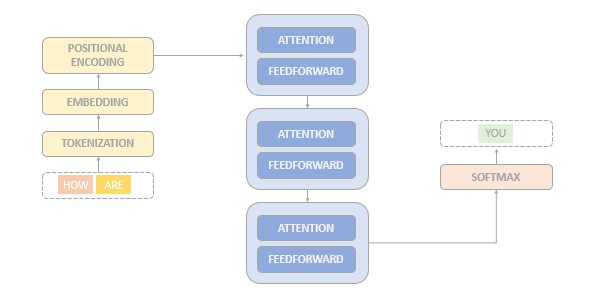

- Tokenization: tokenization is the process of creating basic units of the
original text that is processed by the underlying model, sophisticated tokenization algorithms, words are often broken down into smaller subword units – this approach allows the model to handle rare words, compound words and out-of-vocabulary words more efficiently. 
For example, unhappy is broken as un + happy 

- Static Emebeddings: Static Embeddings generated in the first layer and combine token embeddings (vectors representing tokens) . But static embedding lacks the ordering/positional knowledge, for example, the word 'bank' in river bank and bank robbery are different.

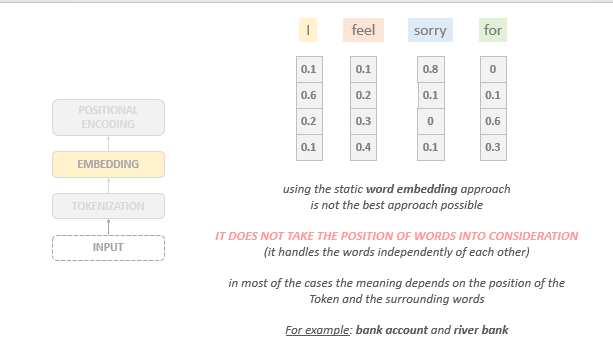


- Positional Embedding
Transformers don’t have recurrence or convolution, so they:

Process all tokens in parallel

Don’t inherently understand the order of words

👉 This means "dog bites man" and "man bites dog" look the same to a transformer — unless we add position informations

A positional embedding is a vector that encodes the position of a word in a sentence.
It is added to (or concatenated with) the word embedding so the model knows where each word is.
Final Input = Word Embedding + Positional Embedding

This embedding is deterministic, for position pos and dimension i, 

PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

pos = 1, d_model = 4
[sin(1/10000^0), cos(1/10000^0), sin(1/10000^0.5), cos(1/10000^0.5)]

Can be sinusoidal (fixed) or learned (trainable)

The position can take values from 1 to length of the sentence and each sentence can be of different lengths, so in this case the sinusoidal positional encoding is very useful as we dont need to know the length of the vectors prior.

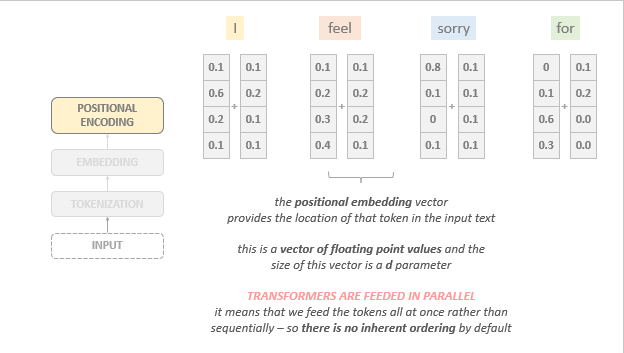



- Self Attention
is used to generate context aware representations of the input tokens.

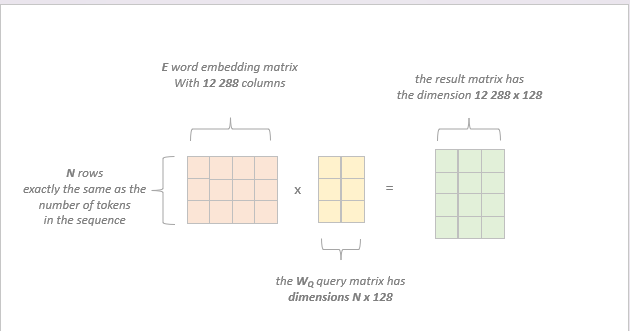


Sequence length = T

Embedding dimension = d_model

Number of heads = h

Dimension per head = d_k = d_model / h

For example, if d_model = 512 and h = 8, then d_k = 64.

Step-by-Step Dimensions in Self-Attention
1. Input Embedding Matrix
Shape: [T × d_model]

Each row corresponds to a token’s vector in the sequence (after token + positional embedding).

2. Learnable Projection Matrices
We project the input into:

Query (Q)

Key (K)

Value (V)

Each has its own learned matrix:

Matrix	Shape	Purpose

W_Q	[d_model × d_k]	Project input to query space

W_K	[d_model × d_k]	Project input to key space

W_V	[d_model × d_v] (usually d_v = d_k)	Project input to value space

If working with multi-head attention, there will be one set of W_Q, W_K, W_V per head.

After projection:

Q = X × W_Q → shape: [T × d_k]

K = X × W_K → shape: [T × d_k]

V = X × W_V → shape: [T × d_k]

3. Attention Scores

Attention(Q, K, V) = softmax(Q × Kᵀ / √d_k) × V
Step-by-step:

Q → [T × d_k]

Kᵀ → [d_k × T]

Q × Kᵀ → [T × T]: similarity scores between all pairs of tokens

softmax(QKᵀ / √d_k) → [T × T]: attention weights for each token

Multiply by V → [T × d_k]: weighted 

- Multihead attention

for i in range(num_heads):
    Q_i = X × W_Qi
    K_i = X × W_Ki
    V_i = X × W_Vi

    head_i = Attention(Q_i, K_i, V_i)

MultiHead(Q, K, V) = Concat(head_1, ..., head_h) × W_O


| Component  | Learns/Extracts                         | Purpose                                 |
| ---------- | --------------------------------------- | --------------------------------------- |
| `W_Q`      | What a word wants to find               | Guides attention queries                |
| `W_K`      | What a word offers to others            | Guides who gets attended to             |
| `W_V`      | What information a word contains        | The actual content passed via attention |
| Attention  | How much focus each word gives/receives | Combines info contextually              |
| Multi-head | Multiple attention patterns in parallel | Captures diverse relationships          |
| `W_O`      | Recombines all heads                    | Produces consistent output dimension    |

the softmax function converts these raw scores into a probability distribution across all token + provides differentiablility for learning and  amplifies stronger signals

The weights of W: the weights (values) of this matrix tell the model how much
focus to put on each token in relation to others  it may suppress or mute the impact of tokens that do not
carry useful information („the” or „a”)


- Masking

We apply a mask to ensure that each token can only attend to itself and earlier tokens for not the future tokens, means any future tokens should not influence the earlier tokens.

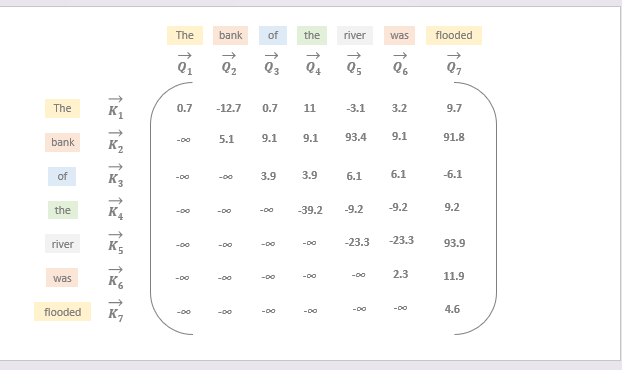


- Padding 

sequeces often have varying length and to handle these, shorter sequences are padded to match longer sequences

In machine translation or text classification, input sequences have variable lengths, so we pad shorter sequences with a [PAD] token.

Sentence 1: "Hello world"        → ["Hello", "world", PAD, PAD]
Sentence 2: "Hi"                 → ["Hi", PAD, PAD, PAD]

If you don't mask the [PAD] tokens:

The model will try to attend to those positions,

Which is meaningless and can confuse learning.

[✓ ✓ 0 0]

[✓ 0 0 0]

Then add this to the attention scores before softmax.
Masked positions (0s) get -inf, and softmax gives them 0 attention.


- Feed Forward Neural Network Layer

After the self attention step, the concatenated value vector is passed through a feed forward neural network, input and output layers of this vnn are of size dmodel. 1 Middle layer with 4*dmodel neurons. It applies non linear transformation on the input.

Every row of the attention output is passed through the neural network independently. It applies non linear transformation on the input, it increases the model capability to learn complex patterns.
So every input token of dmodel length is transformed into a vector of dmodel length. 


- Final Softmax Activation function

After the input tokens pass through the transformer layers, we get N x d_model matrix. 

Let's say:

Vocabulary size = V (e.g., 50,000 words)

Embedding dimension = d_model (e.g., 768)

Sequence length = T (e.g., 10)

Hidden states: shape (T, d_model)

Pass every token vector into a linear layer with V neurons, W= d_model x V + Bias(length V) so that . So if we do this for every token, we now have a score for every word in the vocab. 
Final Matrix : T x V


| Token      | Transformer Output →  | Linear Layer → (len V) | Softmax →                |
| ---------- | --------------------- | ---------------------- | ------------------------ |
| "The"      | \[0.1, 0.3, ..., 0.6] | \[2.3, -0.5, ..., 0.1] | \[0.05, 0.01, ..., 0.07] |
| "refinery" | \[0.2, 0.6, ..., 0.4] | \[1.2, 3.1, ..., -1.5] | \[0.10, 0.60, ..., 0.01] |

We want to convert this into:

A probability distribution over the vocabulary

Then pick the most likely word (or sample from it)


Example Output from Final Layer (Logits)

Let’s assume the model has produced the following logits for the 3 tokens (T=3, V=5):

logits = [
    [2.0, 1.0, 0.1, 0.2, -1.0],   # token 1: "the"

    [0.2, 2.2, 1.5, 0.3, -0.5],   # token 2: "cat"

    [-1.0, 0.5, 3.0, 2.0, 0.1]    # token 3: "sat"
]

Take the logits of token 3 and predict the next word

exp = [e^-1, e^0.5, e^3, e^2, e^0.1 ]

sum = e^-1 + e^0.5 + e^3 + e^2 +e^0.1 

final_prob=[e^-1/sum, e^0.5/sum, e^3/sum, e^2/sum, e^0.1/sum ]

Take the position of the maximum logit and check its position from the vocabularity, u get the next word.


### Training the Transformers

Mimizing the loss function

L= -(sum i=1 to N )(yi * log(yi))


### Encoder Decoder Models, Causal Language Models